## Colab tools
Буду запускать на Колабе, так как у меня не достаточно мощностей на компьютере. :)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir data

In [4]:
!tar -xvf /content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/data/casia_faces.tar.gz -C data

Streaming output truncated to the last 5000 lines.
casia_faces/person_1056/c2042002-d9ba-4408-ae54-593329a9dea5.jpg
casia_faces/person_1056/49f81d2d-4d41-4a9e-b6e2-6e884808f9e3.jpg
casia_faces/person_1056/e5a9391a-f8e9-49a3-a77b-5926235524dd.jpg
casia_faces/person_1056/e41fa0cc-106b-4038-bcbf-6a4d7f3795b4.jpg
casia_faces/person_1056/798b7dc5-cd1a-4667-bf84-d0485581e2b6.jpg
casia_faces/person_1056/c94ddfbe-e443-42e6-bd3f-a57bbda85ebd.jpg
casia_faces/person_1056/7ad3a739-69c6-458c-a3da-577f5c990272.jpg
casia_faces/person_1056/9b9cf6a4-785d-48a6-af70-1d4c3222e763.jpg
casia_faces/person_1056/fd4d7f49-6e4d-43ad-b0e0-c26419afc2bd.jpg
casia_faces/person_1056/b9937108-4c5b-42dc-b04a-5caedcf09065.jpg
casia_faces/person_1056/f7eefaff-ffb2-4799-a96f-0760d3992439.jpg
casia_faces/person_1056/08a908de-ea4d-4068-9e68-fe1a454d7309.jpg
casia_faces/person_1056/efd72e7b-5e14-4611-9dcd-ae58a57275a7.jpg
casia_faces/person_1056/05da8ca2-8593-460b-81c1-2be7b9ecfd15.jpg
casia_faces/person_1056/9ce78d3b-aec2-4

In [5]:
!tar -xvf /content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/data/lfw.tar.gz -C data

Streaming output truncated to the last 5000 lines.
lfw/positive/cf71a063-150c-4950-87c7-b4d2de4d69f3/e9be1ec9-ab6d-40d4-8fe0-872560f110c9.jpg
lfw/positive/cf71a063-150c-4950-87c7-b4d2de4d69f3/c7b36be9-53b3-46e7-a730-fdec8545456a.jpg
lfw/positive/d0f93a76-325f-4d62-a42d-d4291a89f115/
lfw/positive/d0f93a76-325f-4d62-a42d-d4291a89f115/ed3a26a3-b264-430e-bd50-fb73c51002d6.jpg
lfw/positive/d0f93a76-325f-4d62-a42d-d4291a89f115/3ba37ce2-a673-4c16-8f11-29ad9f8e66c0.jpg
lfw/positive/8ef01505-f568-4d23-8ac6-cc219c1301d6/
lfw/positive/8ef01505-f568-4d23-8ac6-cc219c1301d6/63920ca4-56b5-41c5-b3bd-d494b9a6a3ef.jpg
lfw/positive/8ef01505-f568-4d23-8ac6-cc219c1301d6/1138a9a2-26ad-405f-a73d-3ad650415ec3.jpg
lfw/positive/4f685ce7-20c0-4eb8-82e3-29d0b7eabb55/
lfw/positive/4f685ce7-20c0-4eb8-82e3-29d0b7eabb55/915c1613-e58e-47fd-8c0e-e6713dcdae03.jpg
lfw/positive/4f685ce7-20c0-4eb8-82e3-29d0b7eabb55/7de2f47e-bb68-45a1-a0d6-022378aca6ef.jpg
lfw/positive/5a7c9125-dc48-4e2e-a004-7e22cf685c43/
lfw/positive/5a7c

In [6]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.3 MB/s eta 0:00:00


# Обучение сети на датасете CASIA-WEB-FACE с использование SoftMaxLoss и CenterLoss и валидация модели на LFW.

Загрузим все необходимые библиотеки и все функции из вспомогательных файлов.
Соответственно, в model.py лежат доступные виды сетей: Net, SimpleNet, MobNet (для первых двух необходимо задать backbone). В config соответственно можно задать необходимые параметры сети. И в utils остальные вспомогательные функции. В trainval вынесены функции для обучения и валидации.

In [7]:
import sys
sys.path.append('/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition')

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import tqdm
import torch.nn.functional as F
import numpy as np
from utils import CenterLoss, get_paths, LFWDataset, imshow, plot_roc_curve, plot_far_frr
import time
import copy
import sklearn.metrics
from scipy.optimize import brentq
from scipy import interpolate
from config import configurations
from model import Net, MobNet, SimpleNet
from trainval import train, evaluate

import torchvision.transforms as transforms

from torch.autograd import Variable
import os
from pathlib import Path
import glob
from facenet_pytorch import InceptionResnetV1
import matplotlib.pyplot as plt

In [50]:
cfg = configurations[1]

SEED = cfg['SEED']
torch.manual_seed(SEED)

LR_SOFTMAX = cfg['LR_SOFTMAX']
FLAG_CENTER = cfg['FLAG_CENTER']
LR_CENTER = cfg['LR_CENTER']
ALPHA = cfg['ALPHA']
FEAT_DIM = cfg['FEAT_DIM']
ALPHA_1 = cfg['ALPHA_1']
TRAIN_BATCH_SIZE = cfg['TRAIN_BATCH_SIZE']
VAL_BATCH_SIZE = cfg['VAL_BATCH_SIZE']
NUM_EPOCHS = cfg['NUM_EPOCHS']
WEIGHT_DECAY = cfg['WEIGHT_DECAY']

RGB_MEAN = cfg['RGB_MEAN']
RGB_STD = cfg['RGB_STD']

MODEL_NAME = cfg['MODEL_NAME']
TRAIN_PATH = cfg['TRAIN_PATH']
VAL_PATH = cfg['VAL_PATH']
FILE_EXT = cfg['FILE_EXT']
RESCALE_SIZE = 32

Посмотрим что лежит в датасете. К счастью, не нужно аугментировать данные и приводить их к правильному виду. (проводить детекцию лиц и сохранять пары (лиц и их классов) :) ) Единственное, приведем картинки к одноканальному виду, для обучения на MobNet, так как она не использует предобученные backbon'ы. (ниже будет приведено объяснение почему это важно)

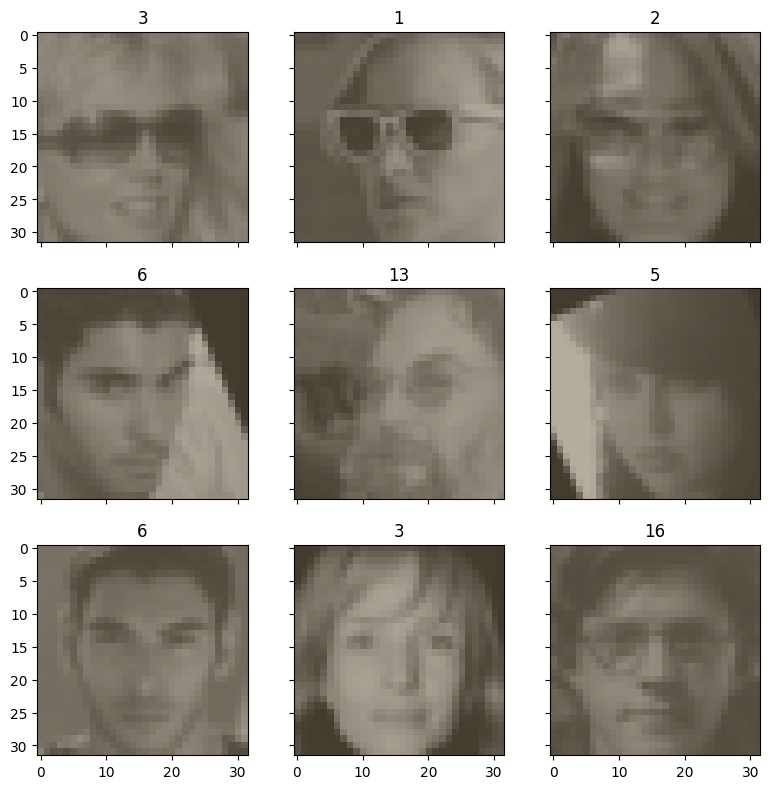

In [51]:
transf = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset1 = datasets.ImageFolder(TRAIN_PATH, transf)
dataset2 = datasets.ImageFolder(VAL_PATH, transf)
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
fig.tight_layout()
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset1[random_characters]
    # print(im_val.shape)
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

Подготовим датасеты и dataloader'ы для дальнейшего обучения и валидации.

In [52]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = datasets.ImageFolder(TRAIN_PATH, train_transform)

In [54]:
# uncomment it for finall train
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
num_class = len(train_loader.dataset.classes)
print('Number of Training Classes: %d' % num_class)

Number of Training Classes: 10572


In [55]:
path_list, issame_list = get_paths(VAL_PATH, FILE_EXT)
val_loader = torch.utils.data.DataLoader(LFWDataset(path_list, issame_list, val_transform), batch_size=VAL_BATCH_SIZE, shuffle=False)

Подготовим модель на базе предобученных моделей.

In [56]:
if MODEL_NAME.lower()=='resnet34':
    backbone = torchvision.models.resnet34(pretrained=True)
elif MODEL_NAME.lower()=='inceptionresnetv1':
    backbone = InceptionResnetV1(pretrained='vggface2')
else:
    backbone = InceptionResnetV1(pretrained='vggface2')

In [58]:
# model = Net(backbone, num_class, ALPHA_1, FEAT_DIM)
model = MobNet(num_class, FEAT_DIM)
print(MODEL_NAME) # check it

MobNet


In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
model.to(device)

Device:  cpu


MobNet(
  (conv_bn_0): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0, inplace=True)
  )
  (stage1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negativ

Для классификации используем Softmax loss, в случае добавления пересчетов центров для каждого пользователя, добавим CenterLoss.
Для простоты будем использовать Adam в качестве оптимайзера.

In [60]:
criterion_softmax = nn.CrossEntropyLoss()
criterion_softmax = criterion_softmax.to(device)
optimizer_softmax = optim.Adam(model.parameters(), lr=LR_SOFTMAX, weight_decay=WEIGHT_DECAY)
# Center loss
if FLAG_CENTER:
    criterion_centerloss = CenterLoss(num_classes=num_class, feat_dim=FEAT_DIM, use_gpu=True)
    optimizer_center = optim.Adam(criterion_centerloss.parameters(), lr=LR_CENTER)
else:
    pass

Обучение и валидация происходят на каждой эпохе, сохраняем checkpoint'ы в models, графики roc_auc в plots.

Epoch 0/0
Epoch 0/0 Batch 0/62
Train Batch Loss: 9.3430 Acc: 0.0000
Epoch 0/0 Batch 1/62
Train Batch Loss: 9.3552 Acc: 0.0000
Epoch 0/0 Batch 2/62
Train Batch Loss: 9.3282 Acc: 0.0000
Epoch 0/0 Batch 3/62
Train Batch Loss: 9.4013 Acc: 0.0000
Epoch 0/0 Batch 4/62
Train Batch Loss: 9.3576 Acc: 0.0000
Epoch 0/0 Batch 5/62
Train Batch Loss: 9.3399 Acc: 0.0000
Epoch 0/0 Batch 6/62
Train Batch Loss: 9.4134 Acc: 0.0000
Epoch 0/0 Batch 7/62
Train Batch Loss: 9.4333 Acc: 0.0000
Epoch 0/0 Batch 8/62
Train Batch Loss: 9.4530 Acc: 0.0000
Epoch 0/0 Batch 9/62
Train Batch Loss: 9.5167 Acc: 0.0000
Epoch 0/0 Batch 10/62
Train Batch Loss: 9.5468 Acc: 0.0000
Epoch 0/0 Batch 11/62
Train Batch Loss: 9.5582 Acc: 0.0000
Epoch 0/0 Batch 12/62
Train Batch Loss: 9.5345 Acc: 0.0000
Epoch 0/0 Batch 13/62
Train Batch Loss: 9.6108 Acc: 0.0000
Epoch 0/0 Batch 14/62
Train Batch Loss: 9.6145 Acc: 0.0000
Epoch 0/0 Batch 15/62
Train Batch Loss: 9.6520 Acc: 0.0000
Epoch 0/0 Batch 16/62
Train Batch Loss: 9.7551 Acc: 0.00

Extracting features: 100%|██████████| 12000/12000 [01:35<00:00, 125.60it/s]


ROC-AUC: 0.5108
LFW VAL AUC: 0.5108, LFW VAL EER: 0.4930
Current Best val ROC AUC: 0.510824
Training complete


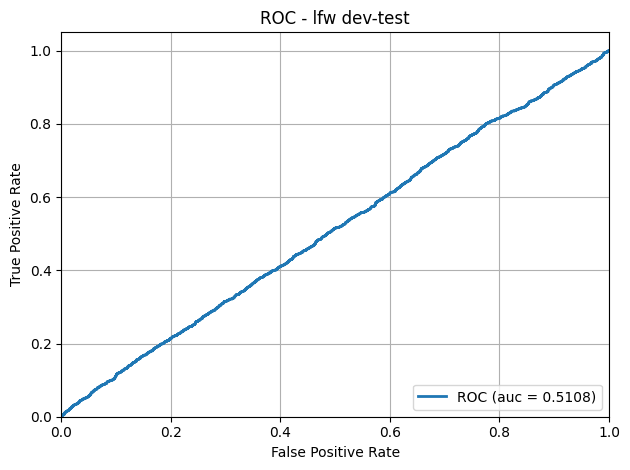

In [63]:
train(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=1,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'test1',
)

Extracting features: 100%|██████████| 12000/12000 [02:09<00:00, 92.44it/s] 


ROC-AUC: 0.5313


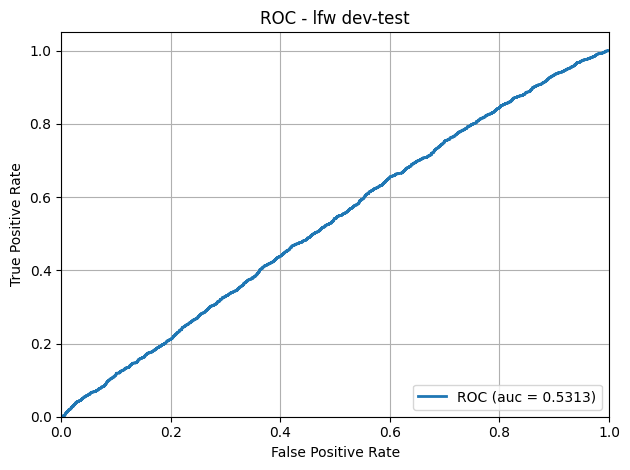

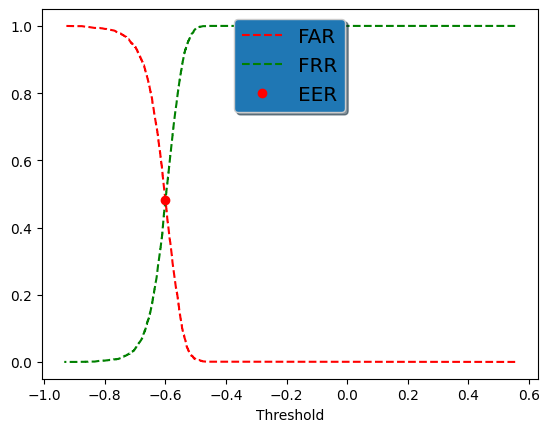

LFW VAL AUC: 0.5313, LFW VAL EER: 0.4810


In [20]:
evaluate(
    model=model.to(device),
    optimizer=optimizer_softmax,
    checkpoint_path='/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/models/MobNet_CASIA-WEB-FACE-Aligned_Epoch_0_LfwAUC_0.468703.tar',
    device=device,
    val_loader=val_loader,
    issame_list=issame_list
)

Да, результаты, конечно, удручающие, но это потому, что мы смотрим точность только после первой эпохи. Сеть еще не успела достаточно обучиться. (мы помним, что классов у нас 10572) Надо бы обучить хотя бы на 90 эпохах, но на данный момент, у меня пока нет сервера, на котором я бы смогла это сделать за приемлемое время.

 Далее рассмотрены сети, которые используют предобученные ResNet и InceptionResNet, в качестве backbon'а. Но так как эти сети изначально обучались на RGB иображениях, с позиции логики, будет неверным подавать черно-белые фото на вход. Можно, конечно, добавить один слой перед backbon'ом, который преобразует входное изображение в 3х канальное, но скорее всего полученный тензор будет иметь мало общего с исходной картинкой и картинкой в принципе, что приведет к бесполезности использования Transfer Learning подхода.

Поэтому подготовим отдельно новые train и val dataloader'ы, которые будут содержать 3х канальные изображения.

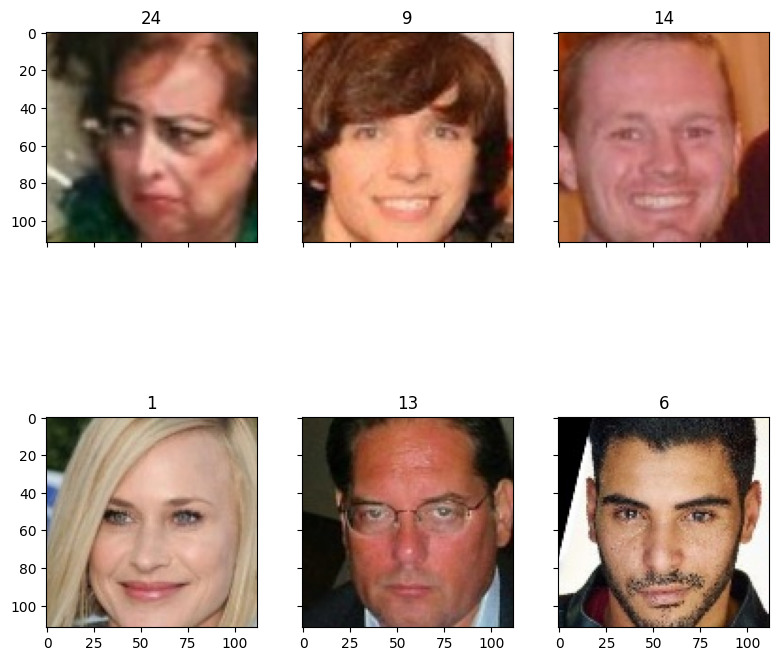

In [65]:
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_MEAN,
                         std=RGB_STD),
])
dataset_casia = datasets.ImageFolder(TRAIN_PATH, transf)
dataset_lfw = datasets.ImageFolder(VAL_PATH, transf)
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
fig.tight_layout()
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset_casia[random_characters]
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

In [66]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_MEAN,std=RGB_STD),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_MEAN,
                         std=RGB_STD),
])

dataset_train = datasets.ImageFolder(TRAIN_PATH, train_transform)

In [67]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
num_class = len(train_loader.dataset.classes)
print('Number of Training Classes: %d' % num_class)
path_list, issame_list = get_paths(VAL_PATH, FILE_EXT)
val_loader = torch.utils.data.DataLoader(LFWDataset(path_list, issame_list, val_transform), batch_size=VAL_BATCH_SIZE, shuffle=False)

Number of Training Classes: 10572


Epoch 0/0
Epoch 0/0 Batch 0/62
Train Batch Loss: 9.2732 Acc: 0.0000
Epoch 0/0 Batch 1/62
Train Batch Loss: 9.2628 Acc: 0.0000
Epoch 0/0 Batch 2/62
Train Batch Loss: 9.2679 Acc: 0.0000
Epoch 0/0 Batch 3/62
Train Batch Loss: 9.2641 Acc: 0.0000
Epoch 0/0 Batch 4/62
Train Batch Loss: 9.2767 Acc: 0.0000
Epoch 0/0 Batch 5/62
Train Batch Loss: 9.2703 Acc: 0.0000
Epoch 0/0 Batch 6/62
Train Batch Loss: 9.2653 Acc: 0.0000
Epoch 0/0 Batch 7/62
Train Batch Loss: 9.2597 Acc: 0.0000
Epoch 0/0 Batch 8/62
Train Batch Loss: 9.2575 Acc: 0.0000
Epoch 0/0 Batch 9/62
Train Batch Loss: 9.2760 Acc: 0.0000
Epoch 0/0 Batch 10/62
Train Batch Loss: 9.2691 Acc: 0.0000
Epoch 0/0 Batch 11/62
Train Batch Loss: 9.2605 Acc: 0.0000
Epoch 0/0 Batch 12/62
Train Batch Loss: 9.2673 Acc: 0.0000
Epoch 0/0 Batch 13/62
Train Batch Loss: 9.2652 Acc: 0.0000
Epoch 0/0 Batch 14/62
Train Batch Loss: 9.2652 Acc: 0.0000
Epoch 0/0 Batch 15/62
Train Batch Loss: 9.2670 Acc: 0.0000
Epoch 0/0 Batch 16/62
Train Batch Loss: 9.2690 Acc: 0.00

Extracting features: 100%|██████████| 12000/12000 [16:22<00:00, 12.22it/s]


ROC-AUC: 0.6073
LFW VAL AUC: 0.6073, LFW VAL EER: 0.4193
Current Best val ROC AUC: 0.607262
Training complete


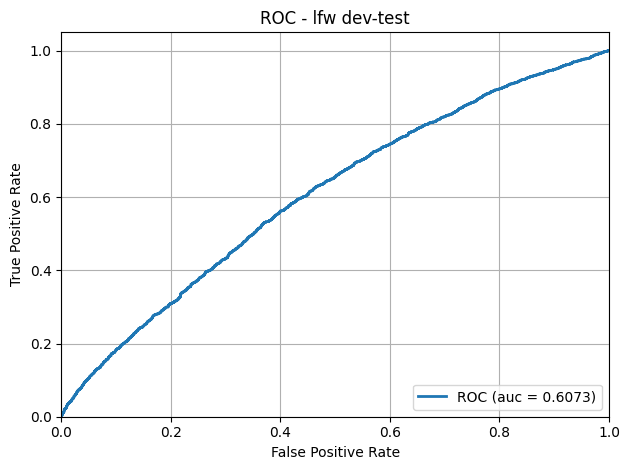

In [36]:
MODEL_NAME = 'SimpleNet'
model_incept = SimpleNet(backbone, num_class)
train(
    train_loader=train_loader_1,
    val_loader=val_loader,
    model=model_incept,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=1,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'test',
)

Extracting features: 100%|██████████| 12000/12000 [15:57<00:00, 12.54it/s]


ROC-AUC: 0.6073


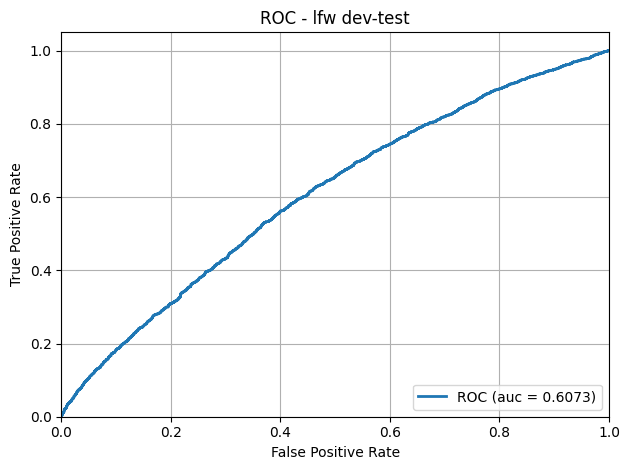

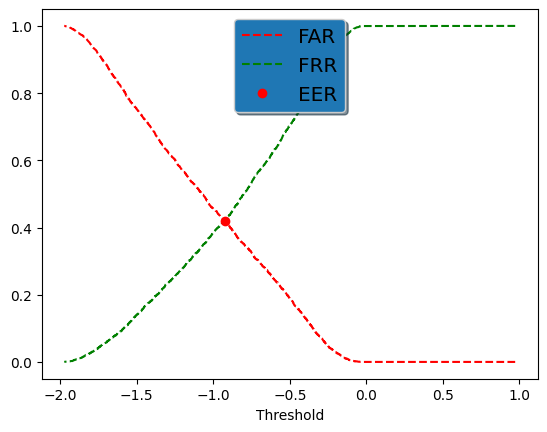

LFW VAL AUC: 0.6073, LFW VAL EER: 0.4193


In [38]:
evaluate(
    model=model_incept.to(device),
    optimizer=optimizer_softmax,
    checkpoint_path='/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/models/SimpleNettest_CASIA-WEB-FACE-Aligned_Epoch_0_LfwAUC_0.6072621666666667.tar',
    device=device,
    val_loader=val_loader,
    issame_list=issame_list
)

In [40]:
LR_SOFTMAX=0.0001

Epoch 0/0
Epoch 0/0 Batch 0/62
Train Batch Loss: 9.2706 Acc: 0.0000
Epoch 0/0 Batch 1/62
Train Batch Loss: 9.2828 Acc: 0.0000
Epoch 0/0 Batch 2/62
Train Batch Loss: 9.2935 Acc: 0.0000
Epoch 0/0 Batch 3/62
Train Batch Loss: 9.2884 Acc: 0.0000
Epoch 0/0 Batch 4/62
Train Batch Loss: 9.2718 Acc: 0.0000
Epoch 0/0 Batch 5/62
Train Batch Loss: 9.2968 Acc: 0.0000
Epoch 0/0 Batch 6/62
Train Batch Loss: 9.2895 Acc: 0.0000
Epoch 0/0 Batch 7/62
Train Batch Loss: 9.2677 Acc: 0.0000
Epoch 0/0 Batch 8/62
Train Batch Loss: 9.2967 Acc: 0.0000
Epoch 0/0 Batch 9/62
Train Batch Loss: 9.2602 Acc: 0.0000
Epoch 0/0 Batch 10/62
Train Batch Loss: 9.2766 Acc: 0.0000
Epoch 0/0 Batch 11/62
Train Batch Loss: 9.2782 Acc: 0.0000
Epoch 0/0 Batch 12/62
Train Batch Loss: 9.2853 Acc: 0.0000
Epoch 0/0 Batch 13/62
Train Batch Loss: 9.2696 Acc: 0.0000
Epoch 0/0 Batch 14/62
Train Batch Loss: 9.2664 Acc: 0.0000
Epoch 0/0 Batch 15/62
Train Batch Loss: 9.2891 Acc: 0.0000
Epoch 0/0 Batch 16/62
Train Batch Loss: 9.2636 Acc: 0.00

Extracting features: 100%|██████████| 12000/12000 [11:36<00:00, 17.22it/s]


ROC-AUC: 0.7193
LFW VAL AUC: 0.7193, LFW VAL EER: 0.3430
Current Best val ROC AUC: 0.719275
Training complete


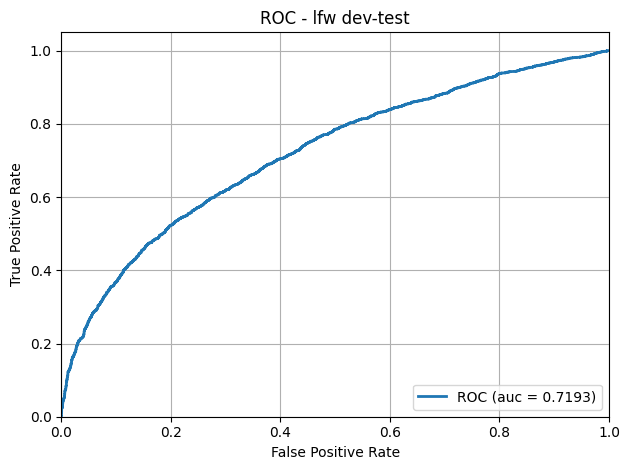

In [47]:
backbone = torchvision.models.resnet34(pretrained=True)
model_net = Net(backbone, num_class, ALPHA_1, FEAT_DIM).to(device)
criterion_softmax = nn.CrossEntropyLoss()
criterion_softmax = criterion_softmax.to(device)
optimizer_softmax = optim.SGD(model.parameters(), lr=LR_SOFTMAX, weight_decay=WEIGHT_DECAY)
MODEL_NAME = 'Net'
train(
    train_loader=train_loader_1,
    val_loader=val_loader,
    model=model_net,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=1,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'test',
)

Extracting features: 100%|██████████| 12000/12000 [11:35<00:00, 17.25it/s]


ROC-AUC: 0.7193


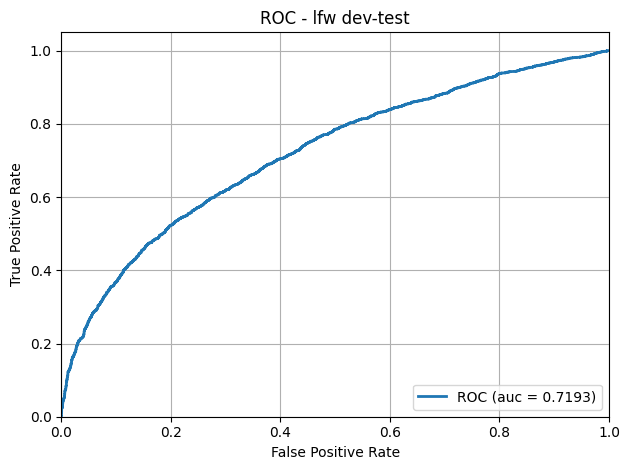

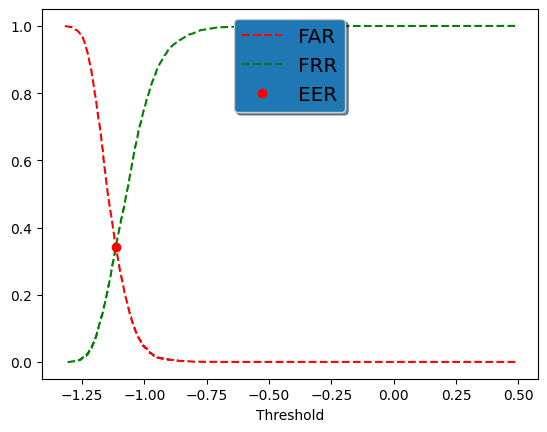

LFW VAL AUC: 0.7193, LFW VAL EER: 0.3430


In [49]:
evaluate(
    model=model_net.to(device),
    optimizer=optimizer_softmax,
    checkpoint_path='/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/models/Nettest_CASIA-WEB-FACE-Aligned_Epoch_0_LfwAUC_0.7192753888888889.tar',
    device=device,
    val_loader=val_loader,
    issame_list=issame_list
)